# Lending Club Loan Payback Classification - Data Engineering and Exploration
## What data are we looking at?
- Thousands of loans made through a lending club platform.
- All loans are not created equally.
- Someone who is sure to pay back will get a loan easier (at low interest) vs someone who appears riskier.
- Those who are very risky may not get a loan offer at all.

#### It is important to keep that last part in mind, since this data set only represents loans actually made, 
**i.e. do not mistake this data for loan applications.**

In this demo - we will analyze the dataset and preprocess it based on our requirements defined by our 'business understanding'

### Business Understanding
- Business understanding is inclined to understanding the business problem and domain.
- Then we define a scope statement.

#### In this use case, we would like to answer the following questions
- We would like to build a classifier to ascertain  whether a customer will be able to repay the loan along with the interest amount
- How does Grade and Sub Grade effect the interest percentage 
- Does the clients credit score play an ifluencial role in predicting thier ability to pay back the loan?
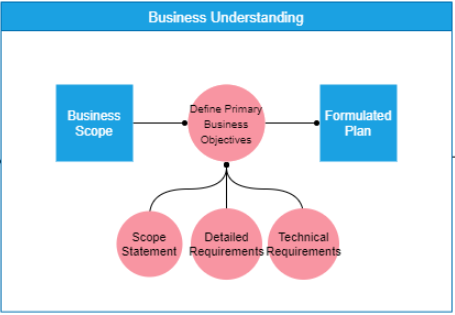

In [97]:
# Loading important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

### Snapshot of the raw data

In [98]:
df = pd.read_csv('lending_club_loans.csv',quotechar='"',sep=',', encoding="utf-8")
df.shape

(42538, 115)

In [99]:
# Looking at the top 5 rows to understand data
pd.set_option('display.max_columns', None)

df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-2015,171.62,NaN,Sep-2016,744.0,740.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2016,499.0,0.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,Jun-2014,649.91,NaN,Sep-2016,719.0,715.0,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [100]:
# Size of the dataset
df.shape

(42538, 115)

This dataset contains 42538 rows and 115 columns. 

In [101]:
# Let us see how many columns are numeric vs textual in nature 
print('Number of Numeric Columns: ',len(list(df.select_dtypes(include=np.number))))
print('Number of Text Columns: ',len(list(df))-len(list(df.select_dtypes(include=np.number))))

Number of Numeric Columns:  90
Number of Text Columns:  25


### Data Preprocessing

These steps include:
1. Checks for nulls (columnar)
2. High cardinality checks
3. Checks of null (rows).
4. Outlier detection.

## 1. Check for nulls

In [102]:
df.isnull().sum().sort_values(ascending=False)

total_il_high_credit_limit     42538
mo_sin_old_rev_tl_op           42538
bc_util                        42538
bc_open_to_buy                 42538
avg_cur_bal                    42538
acc_open_past_24mths           42538
inq_last_12m                   42538
total_cu_tl                    42538
inq_fi                         42538
total_rev_hi_lim               42538
all_util                       42538
max_bal_bc                     42538
open_rv_24m                    42538
open_rv_12m                    42538
il_util                        42538
total_bal_il                   42538
mths_since_rcnt_il             42538
open_il_24m                    42538
open_il_12m                    42538
open_il_6m                     42538
open_acc_6m                    42538
tot_cur_bal                    42538
tot_coll_amt                   42538
verification_status_joint      42538
dti_joint                      42538
total_bc_limit                 42538
mths_since_last_major_derog    42538
m

In [103]:
# Total percentage of null values in the data
round((df.isnull().sum().sum())/(df.shape[0]*df.shape[1]),5)*100

49.5

In fact, 49.5% of the values in the overall data are null values. So, it is very important to carefully deal with these null values as they can significantly affect our results. Out of these 115 columns, many columns have null values in majority.

Most of the columns are float but there are some categorical columns stored as objects. We will look into this issue in the subsequent steps after deciding upon the final columns to consider in the final dataframe .

The next diagram is a missing matrix which a data visualization technique that shows where data is missing. You can read more about the package here: [missingno](https://github.com/ResidentMario/missingno)

The diagram can only comfortably support 50 columns so we can use just one to get an idea and change the slicing to see any others later on
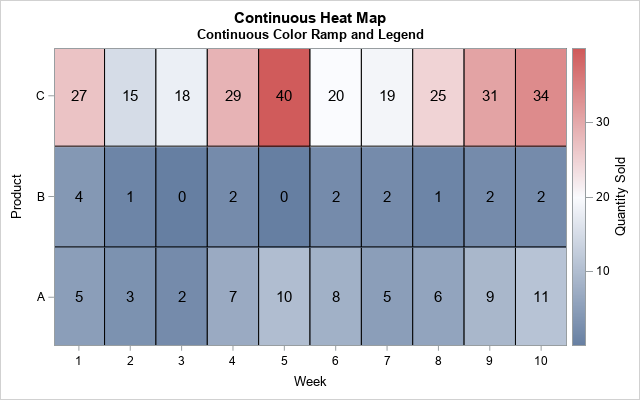

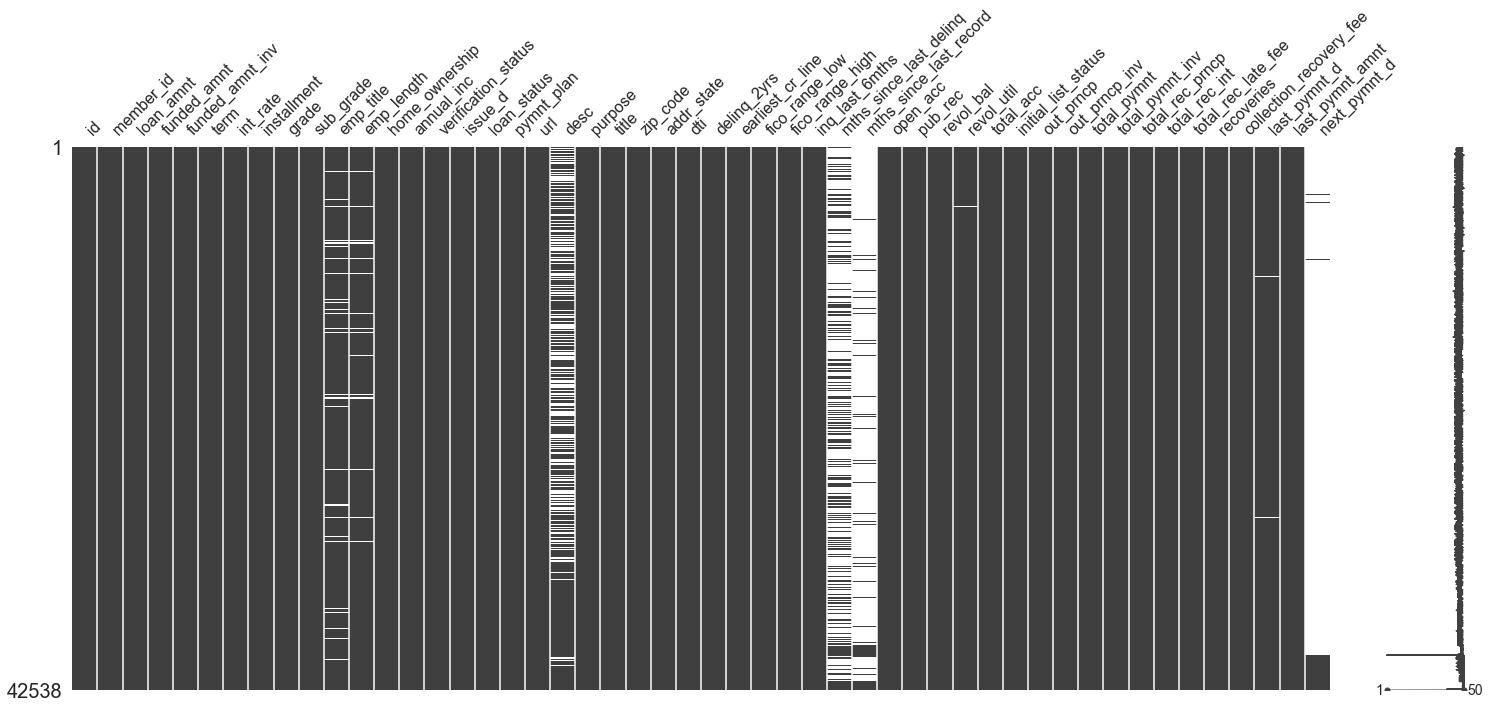

In [104]:
# Checking for null values using a heat map as a visualizing tool
import missingno as msno
%matplotlib inline
msno.matrix(df.iloc[: , :50])

### Handling Null Values

So we know that there are many null values in the data but before we get overwhelmed by trying to impute each one let us try to first find those columns that actually have less data than 50%

In [105]:
# Considering only those columns which have null values less than 40% in that particular column
from functions import missing_zero_values_table
mzt = missing_zero_values_table(df)
mzt_40 = mzt[mzt['% of Total Values']<40]
print(mzt_40.shape)
mzt_40

Your selected dataframe has 115 columns and 42538 Rows.
There are 114 columns that have missing values.
(57, 6)


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
desc,0,13296,31.3,13296,31.3,object
emp_title,0,2629,6.2,2629,6.2,object
pub_rec_bankruptcies,39316,1368,3.2,40684,95.6,float64
emp_length,0,1115,2.6,1115,2.6,object
collections_12_mths_ex_med,42390,148,0.3,42538,100.0,float64
chargeoff_within_12_mths,42390,148,0.3,42538,100.0,float64
tax_liens,42429,108,0.3,42537,100.0,float64
revol_util,0,93,0.2,93,0.2,object
last_pymnt_d,0,86,0.2,86,0.2,object
inq_last_6mths,19657,32,0.1,19689,46.3,float64


By considering columns with less number of null values, we were able to decrease total number of columns from 144 to 57.

In [106]:
# filter df to columns that have less than 40% missing values
df = df[list(mzt_40.index)]

### Shapshot post 40% null column removal

In [107]:
df.head(3)

,desc,emp_title,pub_rec_bankruptcies,emp_length,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,revol_util,last_pymnt_d,inq_last_6mths,pub_rec,total_acc,delinq_amnt,open_acc,earliest_cr_line,acc_now_delinq,delinq_2yrs,title,annual_inc,last_credit_pull_d,loan_status,url,pymnt_plan,home_ownership,issue_d,verification_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,purpose,policy_code,zip_code,addr_state,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,collection_recovery_fee,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,out_prncp_inv,out_prncp,initial_list_status,revol_bal,application_type,fico_range_high,fico_range_low,dti,member_id
0,Borrower added on 12/22/11 > I need to upgra...,NaN,0.0,10+ years,0.0,0.0,0.0,83.7%,Jan-2015,1.0,0.0,9.0,0.0,3.0,Jan-1985,0.0,0.0,Computer,24000.0,Sep-2016,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,n,RENT,Dec-2011,Verified,B2,B,162.87,10.65%,36 months,4975.0,5000.0,credit_card,1.0,860xx,AZ,5000.0,740.0,744.0,171.62,0.00,0.00,0.0,863.16,5000.00,5833.84,5863.155187,0.0,0.0,f,13648.0,INDIVIDUAL,739.0,735.0,27.65,1296599.0
1,Borrower added on 12/22/11 > I plan to use t...,Ryder,0.0,< 1 year,0.0,0.0,0.0,9.4%,Apr-2013,5.0,0.0,4.0,0.0,3.0,Apr-1999,0.0,0.0,bike,30000.0,Sep-2016,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,n,RENT,Dec-2011,Source Verified,C4,C,59.83,15.27%,60 months,2500.0,2500.0,car,1.0,309xx,GA,2500.0,0.0,499.0,119.66,1.11,117.08,0.0,435.17,456.46,1008.71,1008.710000,0.0,0.0,f,1687.0,INDIVIDUAL,744.0,740.0,1.00,1314167.0
2,NaN,NaN,0.0,10+ years,0.0,0.0,0.0,98.5%,Jun-2014,2.0,0.0,10.0,0.0,2.0,Nov-2001,0.0,0.0,real estate business,12252.0,Sep-2016,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,n,RENT,Dec-2011,Not Verified,C5,C,84.33,15.96%,36 months,2400.0,2400.0,small_business,1.0,606xx,IL,2400.0,715.0,719.0,649.91,0.00,0.00,0.0,605.67,2400.00,3005.67,3005.666844,0.0,0.0,f,2956.0,INDIVIDUAL,739.0,735.0,8.72,1313524.0


In [108]:
# Checking info of updated dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 57 columns):
desc                          29242 non-null object
emp_title                     39909 non-null object
pub_rec_bankruptcies          41170 non-null float64
emp_length                    41423 non-null object
collections_12_mths_ex_med    42390 non-null float64
chargeoff_within_12_mths      42390 non-null float64
tax_liens                     42430 non-null float64
revol_util                    42445 non-null object
last_pymnt_d                  42452 non-null object
inq_last_6mths                42506 non-null float64
pub_rec                       42506 non-null float64
total_acc                     42506 non-null float64
delinq_amnt                   42506 non-null float64
open_acc                      42506 non-null float64
earliest_cr_line              42506 non-null object
acc_now_delinq                42506 non-null float64
delinq_2yrs                   42506 non-null floa

There are still some columns like emp_title and desc which have lot of null values. In the following steps, we will look into other columns as well to check for their importance and then decide on whether to include them in the final dataframe. 

## Understanding Features

It is important to understand the features/columns as some of the categorical columns present in the data are in the form of numerical values and vice-versa. We first tried to examine every column but later understood that it will be quite cumbersome to perform these operations to all 53 columns. So, we decided to first eliminate columns which doesn’t add value to the data and then analyze each field.

In [109]:
# we have two types of data 
# text and numeric
print('Number of Numeric Columns: ',len(list(df.select_dtypes(include=np.number))))
print('Number of Text Columns: ',len(list(df))-len(list(df.select_dtypes(include=np.number))))

Number of Numeric Columns:  34
Number of Text Columns:  23


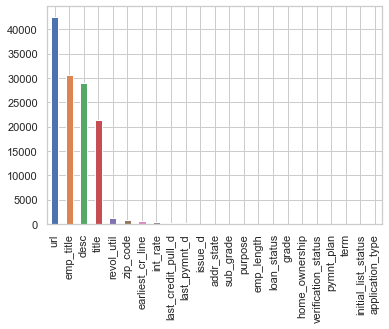

In [110]:
# Checking columns that are of text and thier respective number of unique values
df[df.columns[df.dtypes == 'object']].nunique().sort_values(ascending=False).plot.bar()

#### Feature processing considerations

- High-cardinality refers to columns with values that are very uncommon or unique. High-cardinality column values are typically identification numbers, email addresses, or user names. An example of a data table column with high-cardinality would be a USERS table with a column named USER_ID
- Constant features are the type of features that contain only one value for all the outputs in the dataset. Constant features provide no information that can help in classification of the record at hand. Therefore, it is advisable to remove all the constant features from the dataset. They can also occur where as "Quasi Constant" where one value holds the majority of the records. (extremely imbalanced)

#### Reasoning for dropping some columns 

- emp_title - high cardinality in employee title.
- payment_plan - is a constant value.
- desc - High cardinality. Requires some form of text analytics.
- title - High cardinality. Requires some form of text analytics.
- zip_code - Requires geospatial analytics.
- addr_state - Requires geospatial analytics.
- initial_list_status - is a constant value.
- application_type - is a constant value.
- url - high cardinality in lending club url
- member_id - high cardinality in member id

In [111]:
# After observing the above output, we are dropping columns which are not important and which doesn't add value to our use case.

df.drop(['emp_title','pymnt_plan','desc','title', 'zip_code', 'addr_state', 'initial_list_status','application_type','url','member_id'],axis=1,inplace=True)

In [ ]:
# Similarly, checking some numerical columns
col = ['acc_now_delinq','chargeoff_within_12_mths','collection_recovery_fee',
         'collections_12_mths_ex_med','delinq_amnt','policy_code','tax_liens']
for i in col:
    print(df[i].value_counts())
    print('************************')

0.0    42502
1.0        4
Name: acc_now_delinq, dtype: int64
************************
0.0    42390
Name: chargeoff_within_12_mths, dtype: int64
************************
0.0    42390
Name: collections_12_mths_ex_med, dtype: int64
************************
0.0       42504
6053.0        1
27.0          1
Name: delinq_amnt, dtype: int64
************************
1.0    42535
Name: policy_code, dtype: int64
************************
0.0    42429
1.0        1
Name: tax_liens, dtype: int64
************************


Since these numerical columns contain merely constant values, we resort to dropping them. Some are quasi constant (majoritory of the data belongs to a single value `(>99%)`)

In [112]:
df.drop(['acc_now_delinq','chargeoff_within_12_mths','collection_recovery_fee',
         'collections_12_mths_ex_med','delinq_amnt','policy_code','tax_liens'],axis=1,inplace=True)


df.shape
# We were able to decrease no.of columns from 53 to 36 and we will still try to decrease the no.of columns.

(42538, 40)

After dropping these columns, we double-check the null value matrix

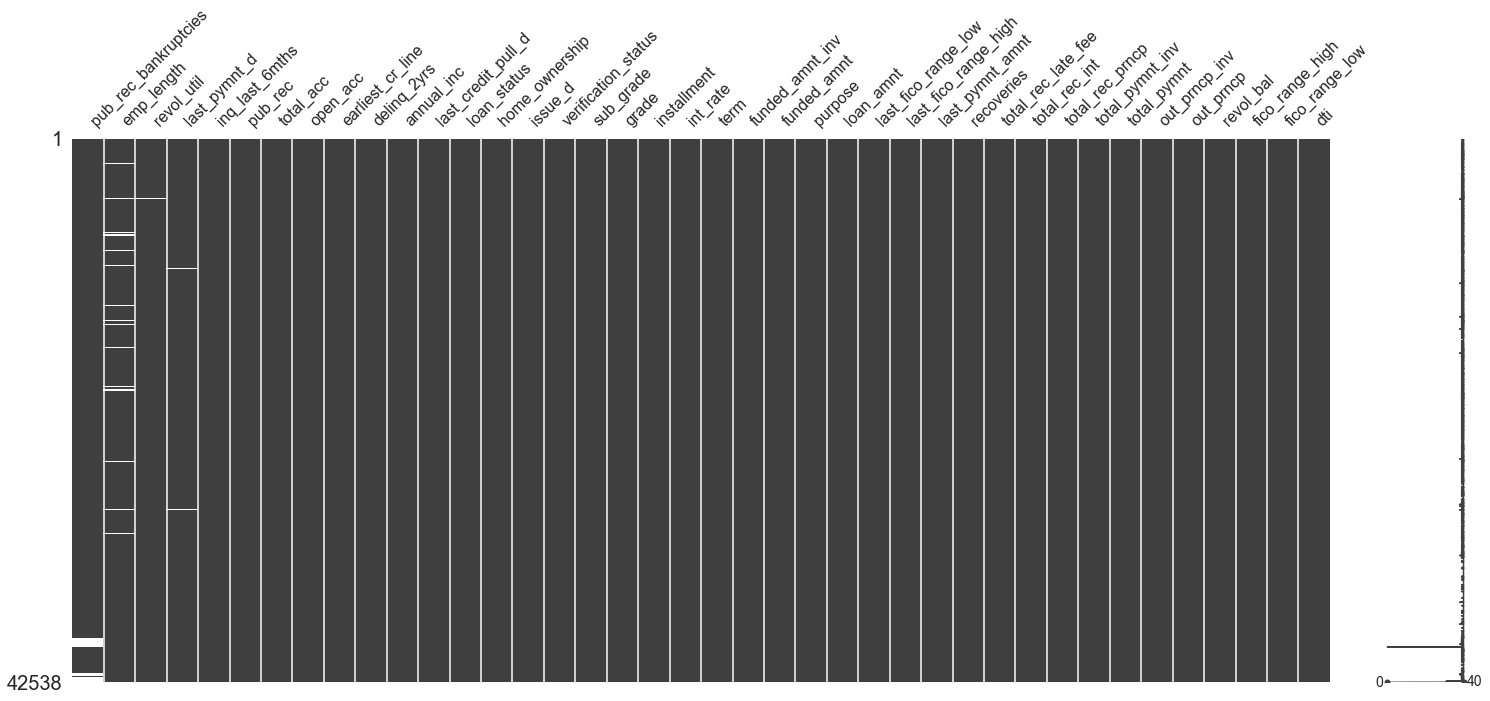

In [113]:
# Checking for null values in the updated dataframe
%matplotlib inline
msno.matrix(df)

Our shape has now changed, since we have dropped some more columns: 53 --> 40 columns.

In [114]:
# Checking two columns which are the same. 
check_df = df[df['out_prncp'] != df['out_prncp_inv']] # Both are same 

# only 274 rows are different and looking at the differences they arent much different at all 

# Dropping those columns to avoid multi-collinearity
df.drop('out_prncp_inv',axis=1,inplace = True)
df.drop('out_prncp',axis=1,inplace = True)
check_df[['out_prncp','out_prncp_inv']].head(10)

,out_prncp,out_prncp_inv
32,956.96,954.52
39,1126.24,1123.96
86,1361.38,1358.91
95,1622.00,1619.35
242,1847.83,1845.29
285,1285.12,1283.25
321,1383.33,1379.87
333,886.93,885.18
335,1454.39,1452.47
417,1460.71,1458.43


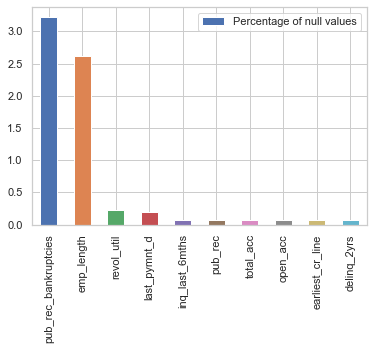

In [115]:
# Checking for null values
# Percentage of null values
a = (df.isnull().sum()/df.shape[0])*100
b = a[a>0.05]
b = pd.DataFrame(b,columns=['Percentage of null values'])
b = b.sort_values(by=['Percentage of null values'],ascending=False)

b.plot(y='Percentage of null values',kind='bar')

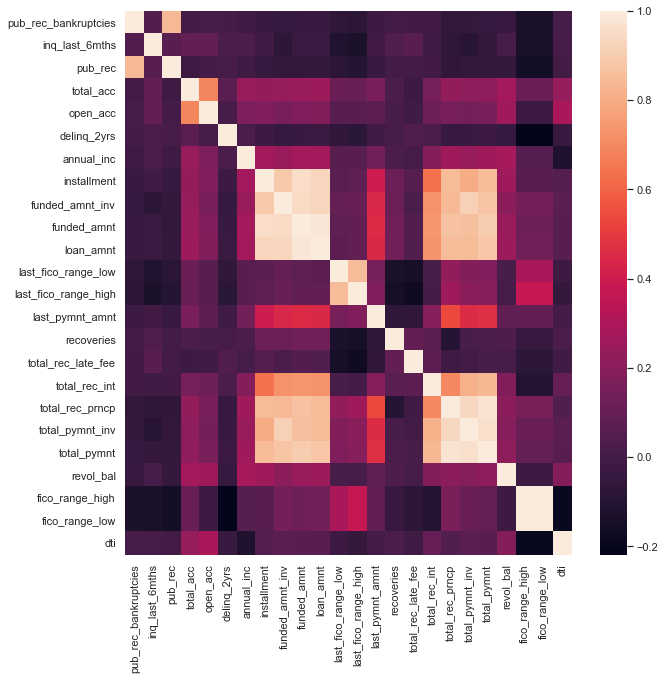

In [116]:
# Checking correlation  and using heatmap to visualise it.
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style('whitegrid')
# Heatmap
sns.heatmap(df.corr(),annot=False)
plt.show()

In [117]:
df.head()


,pub_rec_bankruptcies,emp_length,revol_util,last_pymnt_d,inq_last_6mths,pub_rec,total_acc,open_acc,earliest_cr_line,delinq_2yrs,annual_inc,last_credit_pull_d,loan_status,home_ownership,issue_d,verification_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,purpose,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,revol_bal,fico_range_high,fico_range_low,dti
0,0.0,10+ years,83.7%,Jan-2015,1.0,0.0,9.0,3.0,Jan-1985,0.0,24000.0,Sep-2016,Fully Paid,RENT,Dec-2011,Verified,B2,B,162.87,10.65%,36 months,4975.0,5000.0,credit_card,5000.0,740.0,744.0,171.62,0.00,0.00,863.16,5000.00,5833.84,5863.155187,13648.0,739.0,735.0,27.65
1,0.0,< 1 year,9.4%,Apr-2013,5.0,0.0,4.0,3.0,Apr-1999,0.0,30000.0,Sep-2016,Charged Off,RENT,Dec-2011,Source Verified,C4,C,59.83,15.27%,60 months,2500.0,2500.0,car,2500.0,0.0,499.0,119.66,117.08,0.00,435.17,456.46,1008.71,1008.710000,1687.0,744.0,740.0,1.00
2,0.0,10+ years,98.5%,Jun-2014,2.0,0.0,10.0,2.0,Nov-2001,0.0,12252.0,Sep-2016,Fully Paid,RENT,Dec-2011,Not Verified,C5,C,84.33,15.96%,36 months,2400.0,2400.0,small_business,2400.0,715.0,719.0,649.91,0.00,0.00,605.67,2400.00,3005.67,3005.666844,2956.0,739.0,735.0,8.72
3,0.0,10+ years,21%,Jan-2015,1.0,0.0,37.0,10.0,Feb-1996,0.0,49200.0,Apr-2016,Fully Paid,RENT,Dec-2011,Source Verified,C1,C,339.31,13.49%,36 months,10000.0,10000.0,other,10000.0,600.0,604.0,357.48,0.00,16.97,2214.92,10000.00,12231.89,12231.890000,5598.0,694.0,690.0,20.00
4,0.0,1 year,53.9%,Sep-2016,0.0,0.0,38.0,15.0,Jan-1996,0.0,80000.0,Sep-2016,Current,RENT,Dec-2011,Source Verified,B5,B,67.79,12.69%,60 months,3000.0,3000.0,other,3000.0,690.0,694.0,67.79,0.00,0.00,1055.27,2729.22,3784.49,3784.490000,27783.0,699.0,695.0,17.94


We can see some columns having high correlation but we aren't dropping these columns as yet. These columns might not be even considered while solving our particular question. We will investigate the implications of these columns later - bear in mind that we should not merely drop all attributes that display multicollinearity and in some cases we may actually make use of them as input variables.

In [118]:
# Now that we have come to a conclusion on which columns to consider in the final data frame, we can drop rows which have only null values.
df.dropna(how='all',inplace=True) 
# Dropping rows which have only null values in all the columns

In [119]:
# Checking the final shape of the dataframe
df.shape
#  we can see only 50 rows dropped

(42535, 38)

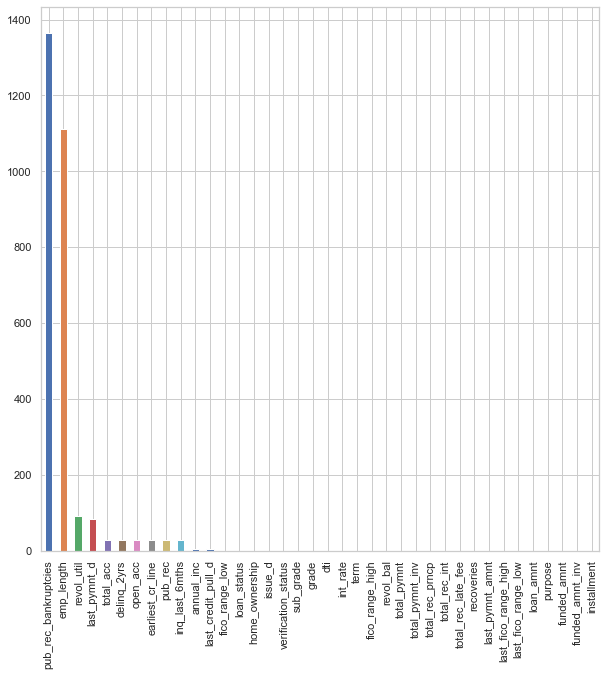

In [120]:
# Checking if still there are any null values
df.isnull().sum().sort_values(ascending=False).plot.bar()

##### There are still few null values which we will deal in the end after pre-processing our date time and categorical columns

## Creating Date Time Features 

- The columns [‘issue_d’,’last_pymnt_d’,’last_credit_pull_d’] which are datetime columns are further divided into month and year by using pandas datetime module. 
- The new columns are named as ‘issue_d_year’, ‘issue_d_month’, ‘last_pymnt_d_year’, ‘last_pymnt_d_month’, ‘last_credit_pull_d_year’, ‘last_credit_pull_d_month’ respectively.

In [121]:
# Checking the datetime columns
df[['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']]

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2011,Jan-1985,Jan-2015,Sep-2016
1,Dec-2011,Apr-1999,Apr-2013,Sep-2016
2,Dec-2011,Nov-2001,Jun-2014,Sep-2016
3,Dec-2011,Feb-1996,Jan-2015,Apr-2016
4,Dec-2011,Jan-1996,Sep-2016,Sep-2016
5,Dec-2011,Nov-2004,Jan-2015,Jan-2016
6,Dec-2011,Jul-2005,May-2016,Sep-2016
7,Dec-2011,Jan-2007,Jan-2015,Dec-2014
8,Dec-2011,Apr-2004,Apr-2012,Sep-2016
9,Dec-2011,Sep-2004,Nov-2012,Sep-2016


In [122]:
# Converting objects to datetime columns
col = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
for i in col:
    df[i] = pd.to_datetime(df[i].astype('str'),  
    infer_datetime_format=True,
    yearfirst=False)

In [123]:
# Checking the new datetime columns
df[['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']]

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2016-09-01
1,2011-12-01,1999-04-01,2013-04-01,2016-09-01
2,2011-12-01,2001-11-01,2014-06-01,2016-09-01
3,2011-12-01,1996-02-01,2015-01-01,2016-04-01
4,2011-12-01,1996-01-01,2016-09-01,2016-09-01
5,2011-12-01,2004-11-01,2015-01-01,2016-01-01
6,2011-12-01,2005-07-01,2016-05-01,2016-09-01
7,2011-12-01,2007-01-01,2015-01-01,2014-12-01
8,2011-12-01,2004-04-01,2012-04-01,2016-09-01
9,2011-12-01,2004-09-01,2012-11-01,2016-09-01


*Now that we have the dates in the correct format let us derive some features from the date dimension that will assist the model*

In [124]:
# Considering only year of joining for 'earliest_cr_line' column.
df['earliest_cr_line'] = pd.DatetimeIndex(df['earliest_cr_line']).year  

In [125]:
# Adding new features by getting month and year from last_pymnt_d and last_credit_pull_d columns
 
df['last_pymnt_d_year'] = pd.DatetimeIndex(df['last_pymnt_d']).year  
df['last_pymnt_d_month'] = pd.DatetimeIndex(df['last_pymnt_d']).month 
df['last_credit_pull_d_year'] = pd.DatetimeIndex(df['last_credit_pull_d']).year  
df['last_credit_pull_d_month'] = pd.DatetimeIndex(df['last_credit_pull_d']).month 


# using differencing to create lifespan of credit 
df.earliest_cr_line = 2019 - (df.earliest_cr_line)
# using differencing to create amount of years since last payment feature
df.last_pymnt_d_year = 2019 - (df.last_pymnt_d_year)
df.last_credit_pull_d_year = 2019 - (df.last_credit_pull_d_year)

In [126]:
# Dropping the original features to avoid data redundancy
df.drop(['issue_d','last_pymnt_d','last_credit_pull_d'],axis=1,inplace=True)

## Converting categorical to numerical columns

The columns int_rate and term are stored as objects. But upon inspection we can see that the column can easily be convereted to numeric

In [129]:
# Considering 'term' feature
print(df.term.value_counts())
df.int_rate.value_counts()

 36 months    31534
 60 months    11001
Name: term, dtype: int64


 10.99%    970
 11.49%    837
 13.49%    832
  7.51%    787
  7.88%    742
  7.49%    656
 11.71%    609
  9.99%    607
  7.90%    582
  5.42%    573
 11.99%    535
 12.69%    492
 10.37%    470
 12.99%    456
  6.03%    447
  8.49%    445
 12.42%    443
 10.65%    435
 11.86%    418
  5.79%    410
  8.90%    402
 10.59%    400
  7.29%    397
  6.62%    396
 14.27%    391
  9.63%    384
  9.91%    377
 12.53%    356
  5.99%    347
  7.14%    342
          ... 
 23.59%      4
 14.67%      3
 14.57%      3
 24.11%      3
 18.49%      3
 18.86%      3
 16.46%      3
 20.69%      3
 12.62%      3
 22.94%      2
 16.33%      2
 13.84%      2
 21.82%      2
 17.59%      2
 17.28%      2
 20.20%      2
 17.91%      2
 17.09%      2
 17.44%      1
 24.40%      1
 17.78%      1
 18.72%      1
 16.83%      1
 17.46%      1
 22.64%      1
 21.48%      1
 17.72%      1
 16.20%      1
 17.41%      1
 24.59%      1
Name: int_rate, Length: 394, dtype: int64

In [130]:
# Converting term and int_rate to numerical columns
df.term = df.term.apply(lambda x:x.strip())
df.term = df.term.apply(lambda x:x[:2])
df.term = df.term.astype('float')
df.int_rate = df.int_rate.str.rstrip('%').astype(float) / 100
df.head(2)

,pub_rec_bankruptcies,emp_length,revol_util,inq_last_6mths,pub_rec,total_acc,open_acc,earliest_cr_line,delinq_2yrs,annual_inc,loan_status,home_ownership,verification_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,purpose,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,revol_bal,fico_range_high,fico_range_low,dti,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month
0,0.0,10+ years,83.7%,1.0,0.0,9.0,3.0,34.0,0.0,24000.0,Fully Paid,RENT,Verified,B2,B,162.87,0.1065,36.0,4975.0,5000.0,credit_card,5000.0,740.0,744.0,171.62,0.00,0.0,863.16,5000.00,5833.84,5863.155187,13648.0,739.0,735.0,27.65,4.0,1.0,3.0,9.0
1,0.0,< 1 year,9.4%,5.0,0.0,4.0,3.0,20.0,0.0,30000.0,Charged Off,RENT,Source Verified,C4,C,59.83,0.1527,60.0,2500.0,2500.0,car,2500.0,0.0,499.0,119.66,117.08,0.0,435.17,456.46,1008.71,1008.710000,1687.0,744.0,740.0,1.00,6.0,4.0,3.0,9.0


- The features above were simple because they were numerical columns that jus required some clean up
- For pure categorical features we decompose them in the following ways:
##### Label Encoding - This approach is very simple and it involves converting each value in a column to a number.

![LabelEncoding](https://miro.medium.com/max/772/1*Yp6r7m82IoSnnZDPpDpYNw.png "Label Encoding")

##### One-hot encoding - We convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. This is also called a `dummy` variable

![HotEncoding](https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png "One Hot Encoding")

### Understanding grade.

Grade associated with the loan. For more information: https://www.lendingclub.com/foliofn/rateDetail.action

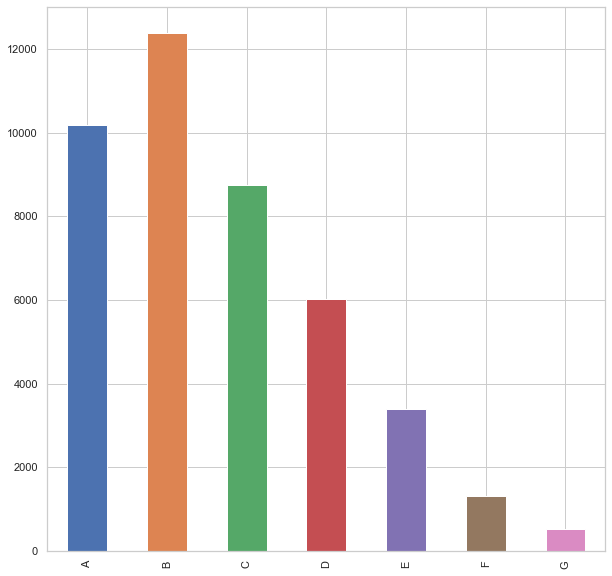

In [131]:
# Considering 'grade' feature
df.grade.value_counts().sort_index(ascending=True).plot.bar()

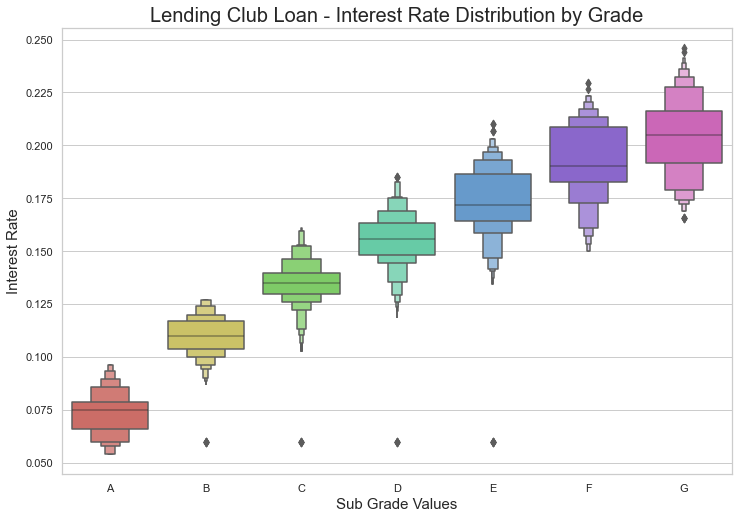

In [132]:
order_grade = df.groupby("grade")['int_rate'].count().index
plt.figure(figsize=(12,8))

plt.subplot(111)
g2 = sns.boxenplot(x="grade", y="int_rate", data=df, 
                   palette="hls", order=order_grade)
g2.set_xlabel("Sub Grade Values", fontsize=15)
g2.set_ylabel("Interest Rate", fontsize=15)
g2.set_title("Lending Club Loan - Interest Rate Distribution by Grade", fontsize=20)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

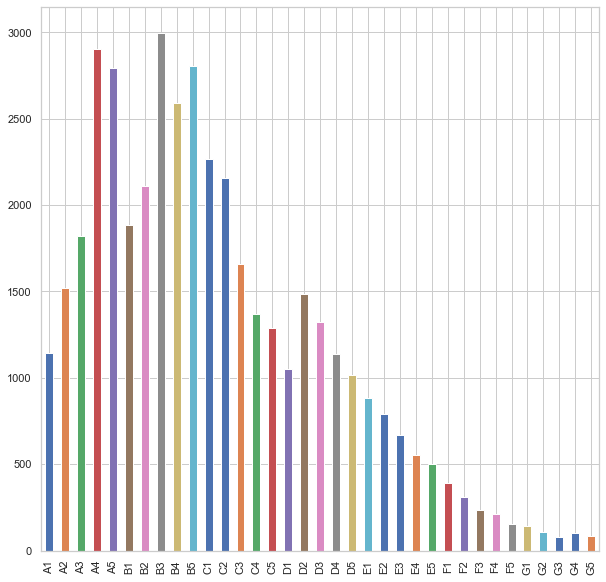

In [133]:
# Considering 'sub_grade' feature
df.sub_grade.value_counts().sort_index(ascending=True).plot.bar()

### Is this situation what encoding do you think we use? 

Both grade and sub_grade features are categorical feature. 
We can perform label encoding on top of these features.

In [134]:
# Label encoding on grade column
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.grade)
le.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

In [135]:
df.grade = le.transform(df.grade)
df.grade

0        1
1        2
2        2
3        2
4        1
5        0
6        2
7        4
8        5
9        1
10       2
11       1
12       2
13       1
14       1
15       3
16       2
17       0
18       1
19       0
20       2
21       1
22       1
23       1
24       1
25       1
26       2
27       3
28       1
29       1
        ..
42506    3
42507    3
42508    3
42509    3
42510    1
42511    4
42512    0
42513    2
42514    1
42515    1
42516    2
42517    2
42518    4
42519    0
42520    0
42521    0
42522    0
42523    0
42524    3
42525    2
42526    2
42527    1
42528    1
42529    1
42530    1
42531    2
42532    1
42533    1
42534    0
42535    0
Name: grade, Length: 42535, dtype: int32

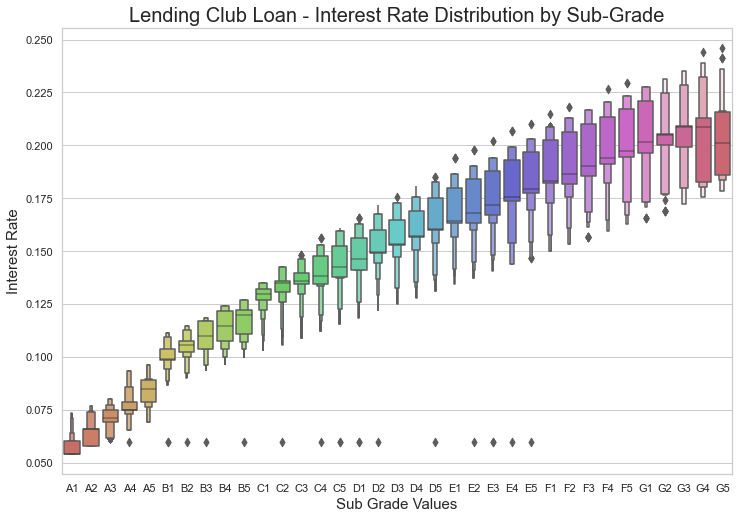

In [136]:
order_sub = df.groupby("sub_grade")['int_rate'].count().index

plt.figure(figsize=(12,8))

plt.subplot(111)
g2 = sns.boxenplot(x="sub_grade", y="int_rate", data=df, 
                   palette="hls", order=order_sub)
g2.set_xlabel("Sub Grade Values", fontsize=15)
g2.set_ylabel("Interest Rate", fontsize=15)
g2.set_title("Lending Club Loan - Interest Rate Distribution by Sub-Grade", fontsize=20)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


In [137]:
# Label encoding on grade column
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.sub_grade)
le.classes_

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

In [138]:
df.sub_grade = le.transform(df.sub_grade)

In [139]:
# One hot encoding on categorical columns
# remmber the argument drop_first = True is going to drop the original columns 
df = pd.get_dummies(df,columns = ['home_ownership','verification_status','purpose'],drop_first = True)

home =[col for col in df if col.startswith('home_ownership')]
df[home].head(3)

,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1


## Dealing with null values (row):
We check for the left-over null values and deal with these respectively.

Percentage of null values:


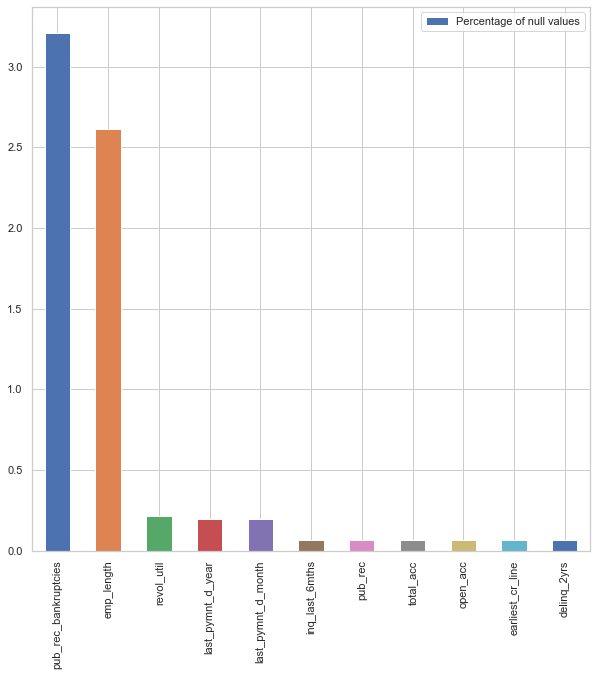

In [140]:
# Checking for null values
# Percentage of null values with greater than 0.5 % missing values 
print('Percentage of null values:')
a = (df.isnull().sum()/df.shape[0])*100
b = a[a>0.05]
b = pd.DataFrame(b,columns=['Percentage of null values'])
b = b.sort_values(by=['Percentage of null values'],ascending=False)
b.plot(y='Percentage of null values',kind='bar')

There are only two columns whose percentage of null values is greater than 2.0%.

Now we check where the null values exist specifically where we can drop explicit rows. we see that the last 6 columns have the same amount of missing values, lets investigate

In [141]:
# Where are the nulls?
df[df['delinq_2yrs'].isnull()].head()

,pub_rec_bankruptcies,emp_length,revol_util,inq_last_6mths,pub_rec,total_acc,open_acc,earliest_cr_line,delinq_2yrs,annual_inc,loan_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,revol_bal,fico_range_high,fico_range_low,dti,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
42450,NaN,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Does not meet the credit policy. Status:Fully ...,1,0,155.38,0.0743,36.0,3025.0,5000.0,5000.0,800.0,804.0,157.31,0.0,0.0,593.63,5000.0,3384.14,5593.631614,0.0,804.0,800.0,1.0,9.0,8.0,12.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42451,NaN,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Does not meet the credit policy. Status:Fully ...,2,0,218.55,0.0775,36.0,3450.0,7000.0,7000.0,800.0,804.0,220.03,0.0,0.0,867.66,7000.0,3877.63,7867.655865,0.0,804.0,800.0,1.0,9.0,8.0,12.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42460,NaN,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120000.0,Does not meet the credit policy. Status:Fully ...,3,0,136.45,0.0807,36.0,825.0,4350.0,4350.0,0.0,0.0,139.93,0.0,0.0,561.99,4350.0,931.59,4911.992738,0.0,744.0,740.0,4.0,9.0,8.0,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42473,NaN,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98000.0,Does not meet the credit policy. Status:Fully ...,7,1,124.62,0.0933,36.0,2025.0,3900.0,3900.0,705.0,709.0,126.06,0.0,0.0,586.17,3900.0,2329.36,4486.172967,0.0,709.0,705.0,10.0,9.0,8.0,12.0,5.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42481,NaN,< 1 year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Does not meet the credit policy. Status:Fully ...,2,0,209.18,0.0775,36.0,6700.0,6700.0,6700.0,800.0,804.0,209.89,0.0,0.0,830.48,6700.0,7530.48,7530.481427,0.0,804.0,800.0,1.0,9.0,7.0,12.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [142]:
# How many rows contain nulls?
len(df[df['delinq_2yrs'].isnull()])

29

In [143]:
# Dropping the 29 rows which have null values
df = df[df['delinq_2yrs'].notnull()]

In [144]:
df.head(2)

,pub_rec_bankruptcies,emp_length,revol_util,inq_last_6mths,pub_rec,total_acc,open_acc,earliest_cr_line,delinq_2yrs,annual_inc,loan_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,revol_bal,fico_range_high,fico_range_low,dti,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.0,10+ years,83.7%,1.0,0.0,9.0,3.0,34.0,0.0,24000.0,Fully Paid,6,1,162.87,0.1065,36.0,4975.0,5000.0,5000.0,740.0,744.0,171.62,0.00,0.0,863.16,5000.00,5833.84,5863.155187,13648.0,739.0,735.0,27.65,4.0,1.0,3.0,9.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,< 1 year,9.4%,5.0,0.0,4.0,3.0,20.0,0.0,30000.0,Charged Off,13,2,59.83,0.1527,60.0,2500.0,2500.0,2500.0,0.0,499.0,119.66,117.08,0.0,435.17,456.46,1008.71,1008.710000,1687.0,744.0,740.0,1.00,6.0,4.0,3.0,9.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Percentage of null values:


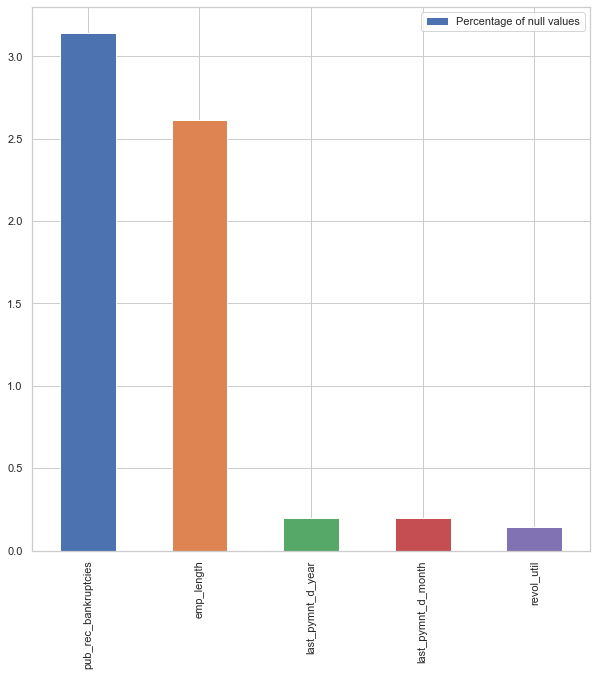

In [145]:
# Checking for null values
# Percentage of null values with greater than 0.5 % missing values 
print('Percentage of null values:')
a = (df.isnull().sum()/df.shape[0])*100
b = a[a>0.05]
b = pd.DataFrame(b,columns=['Percentage of null values'])
b = b.sort_values(by=['Percentage of null values'],ascending=False)
b.plot(y='Percentage of null values',kind='bar')

Some columns have a very little percentage of null values(less than 1%). There we can replace the null values with the median of their respective columns.

In [146]:
# Filling null values with median(string) which is close to 50.
# percentage of money used in day to day expenses 
df.revol_util.fillna('50%',inplace=True)
# Converting string to float
df.revol_util = df.revol_util.apply(lambda x:x[:-1])
df.revol_util = df.revol_util.astype('float')
# As the null values in these columns are less than 0.5% of the size, we are simply imputing null values with median.
# mean vs mediian: mean more senstive is more sensitive to outliers AND MODE IS USED MORE FOR Categorical columns 
df['last_pymnt_d_year'].fillna(df['last_pymnt_d_year'].median(),inplace=True)
df['last_pymnt_d_month'].fillna(df['last_pymnt_d_month'].median(),inplace=True)
df['last_credit_pull_d_year'].fillna(df['last_credit_pull_d_year'].median(),inplace=True)
df['last_credit_pull_d_month'].fillna(df['last_credit_pull_d_month'].median(),inplace=True)

Now that the columns with less than 1% missing values are completed, we now need to look at the columns with larger amounts missing in more detail

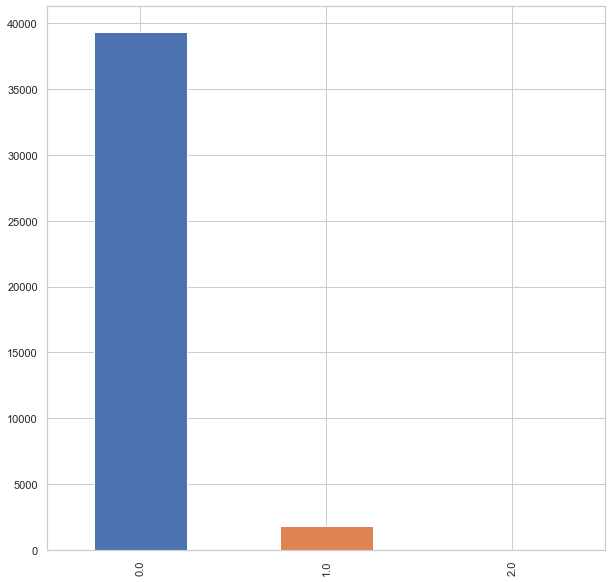

In [147]:

df.pub_rec_bankruptcies.value_counts().plot.bar()

In [148]:
# pub_rec_bankruptcies column is highly imbalanced.
#So, it is better to fill it with median(0) as even after building model the model will be skewed very much towards 0.
df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].median(),inplace=True)

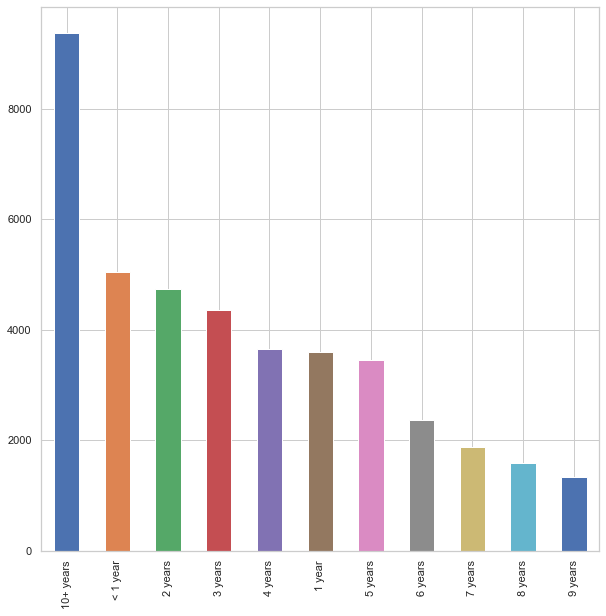

In [149]:
df.emp_length.value_counts().plot.bar()

In [150]:
# we will fill na with the most common emp_length (mode)
df['emp_length'].fillna('10+ years',inplace=True) 
# Filling less than one year as 0 years of experience
df.emp_length.replace({'10+ years':'10 years','< 1 year':'0 years'},inplace=True) 
# Converting it's dtype to float
df.emp_length = df.emp_length.apply(lambda x:x[:2])
df.emp_length = df.emp_length.astype('float')


In [151]:
df.head()

,pub_rec_bankruptcies,emp_length,revol_util,inq_last_6mths,pub_rec,total_acc,open_acc,earliest_cr_line,delinq_2yrs,annual_inc,loan_status,sub_grade,grade,installment,int_rate,term,funded_amnt_inv,funded_amnt,loan_amnt,last_fico_range_low,last_fico_range_high,last_pymnt_amnt,recoveries,total_rec_late_fee,total_rec_int,total_rec_prncp,total_pymnt_inv,total_pymnt,revol_bal,fico_range_high,fico_range_low,dti,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.0,10.0,83.7,1.0,0.0,9.0,3.0,34.0,0.0,24000.0,Fully Paid,6,1,162.87,0.1065,36.0,4975.0,5000.0,5000.0,740.0,744.0,171.62,0.00,0.00,863.16,5000.00,5833.84,5863.155187,13648.0,739.0,735.0,27.65,4.0,1.0,3.0,9.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,9.4,5.0,0.0,4.0,3.0,20.0,0.0,30000.0,Charged Off,13,2,59.83,0.1527,60.0,2500.0,2500.0,2500.0,0.0,499.0,119.66,117.08,0.00,435.17,456.46,1008.71,1008.710000,1687.0,744.0,740.0,1.00,6.0,4.0,3.0,9.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,10.0,98.5,2.0,0.0,10.0,2.0,18.0,0.0,12252.0,Fully Paid,14,2,84.33,0.1596,36.0,2400.0,2400.0,2400.0,715.0,719.0,649.91,0.00,0.00,605.67,2400.00,3005.67,3005.666844,2956.0,739.0,735.0,8.72,5.0,6.0,3.0,9.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.0,10.0,21.0,1.0,0.0,37.0,10.0,23.0,0.0,49200.0,Fully Paid,10,2,339.31,0.1349,36.0,10000.0,10000.0,10000.0,600.0,604.0,357.48,0.00,16.97,2214.92,10000.00,12231.89,12231.890000,5598.0,694.0,690.0,20.00,4.0,1.0,3.0,4.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,1.0,53.9,0.0,0.0,38.0,15.0,23.0,0.0,80000.0,Current,9,1,67.79,0.1269,60.0,3000.0,3000.0,3000.0,690.0,694.0,67.79,0.00,0.00,1055.27,2729.22,3784.49,3784.490000,27783.0,699.0,695.0,17.94,3.0,9.0,3.0,9.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [152]:
# Last check to find if there are any null values
(df.isnull().sum().sum())/(df.shape[0]*df.shape[1])*100

0.0

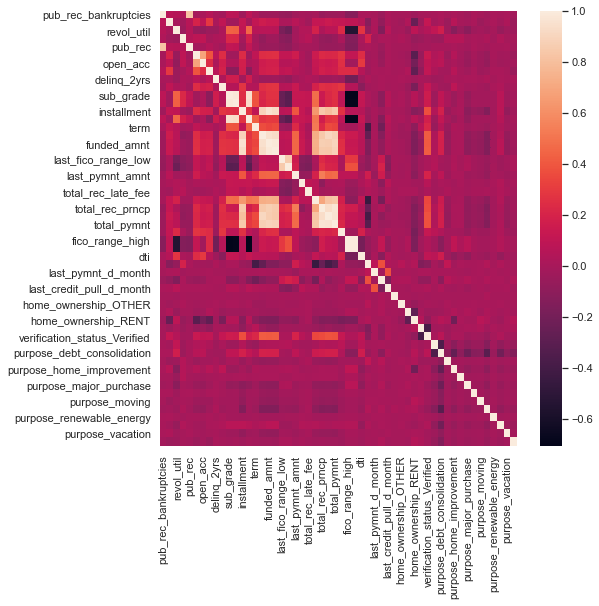

In [153]:
# Heatmap of correlation of the final dataframe
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style('whitegrid')

sns.heatmap(df.corr())
plt.show()

In [154]:
df.shape

(42506, 55)

## Exploratory Data Analysis

What are some key findings around the loan amount?

Text(0, 0.5, 'loan_amnt')

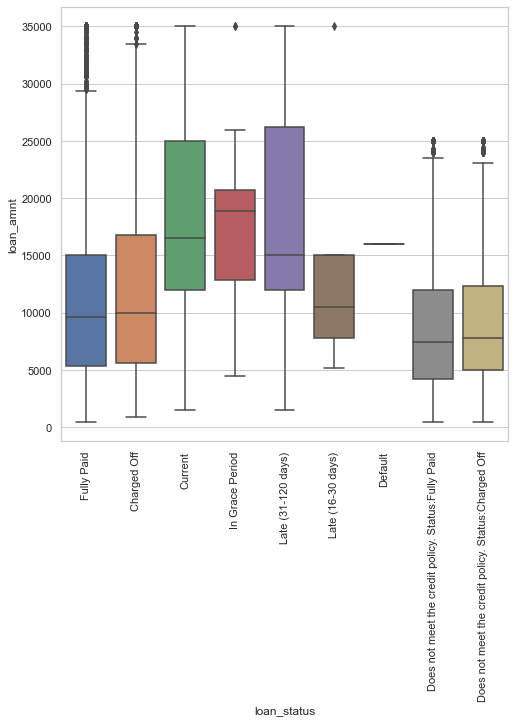

In [155]:
### show distributions 

# loan amount vs income plot
sns.boxplot(y='loan_amnt', x='loan_status',data=df)
plt.xticks(rotation=90)
plt.ylabel('loan_amnt')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


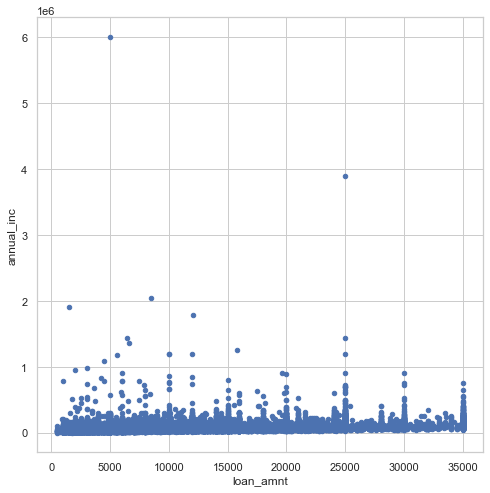

In [156]:
df.plot.scatter('loan_amnt', 'annual_inc')

# Do Outliers Exist?
In most cases yes - and they may be univariate or multivariate in nature. 

A simple univariate example is to perhaps find an individual with an income of 70 million dollars per annum requesting a loan from the lenders club. 

Another more complex example (multivariate) could exist where someone's employee title does not match their income, like a financial manager stating that he earns 700 dollars per annum.

[Some more info,listed here](https://www.kdnuggets.com/2017/01/3-methods-deal-outliers.html#:~:text=In%20this%20article%2C%20we%20have,need%20to%20try%20them%20all.)

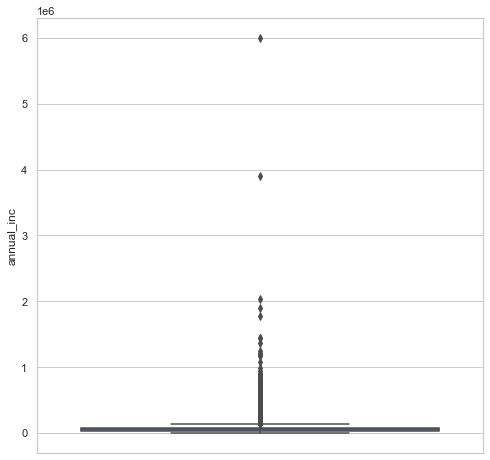

In [157]:
# 
# we need to remomve outliers from annual_inc i.e. 99 to 100%
sns.boxplot(y='annual_inc',data=df)
annual_inc_q = df["annual_inc"].quantile(0.99)
df = df[df["annual_inc"] < annual_inc_q]

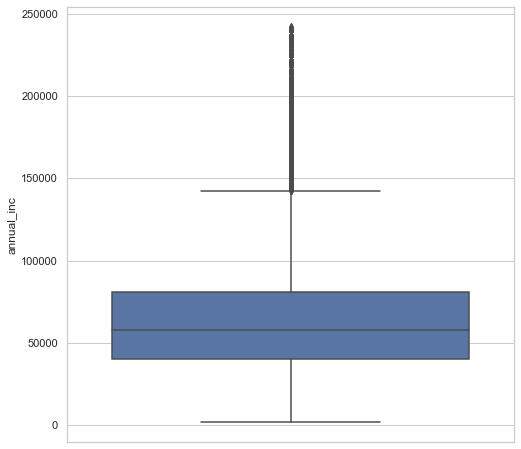

In [158]:
sns.boxplot(y='annual_inc',data=df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


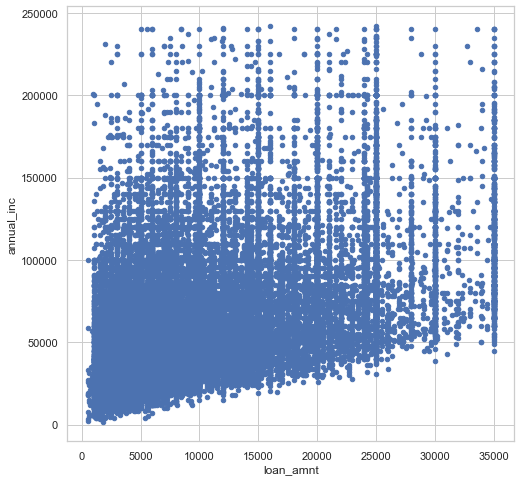

In [159]:
df.plot.scatter('loan_amnt', 'annual_inc')

In [ ]:
df['loan_status'].value_counts().sort_index(ascending=True)

Charged Off                                             5618
Current                                                  507
Default                                                    1
Does not meet the credit policy. Status:Charged Off      741
Does not meet the credit policy. Status:Fully Paid      1917
Fully Paid                                             33263
In Grace Period                                           16
Late (16-30 days)                                          5
Late (31-120 days)                                        12
Name: loan_status, dtype: int64

What we observe from the above value counts is that 
- Majority of the loan_status column belongs to one class (Fully Paid)
- The following values have negligible representation:
    1. In Grace Period
    2. Late (16-30 days)
    3. Late (31-120 days)
    4. Default
- The following values have some representation:
    1. Does not meet the credit policy. Status:Fully Paid 
    2. Does not meet the credit policy. Status:Charged Off
    3. Current
- The following values have majority representation:
    1. Fully Paid
    2. Charged Off

There it was decided to do the following:
| Value Representation | Treatment             |
|----------------------|-----------------------|
| negligible           | discard               |
| some                 | combine with majority |
| majority             | no treatment          |

In [ ]:
#  discard negligible Representation
df = df[df.loan_status.isin(['Fully Paid', 'Charged Off','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Current'])]
# combine some with majority
replace_values = {'Does not meet the credit policy. Status:Fully Paid':'Fully Paid','Does not meet the credit policy. Status:Charged Off':'Charged Off','Current':'Fully Paid' }
df = df.replace({"loan_status": replace_values})
y = df['loan_status'] # target variable
y.value_counts()

Fully Paid     35687
Charged Off     6359
Name: loan_status, dtype: int64

In [ ]:
# Label encoding the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y= le.transform(y)
y

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
# All these columns are based on future transactions(We only want data that contains info before charging off a loan)

df.drop(['total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
        'total_rec_late_fee','recoveries'],inplace=True,axis=1)


In [ ]:
# Checking for multi-collinearity between features

df2 = df.drop('loan_status',axis=1)

vif = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
a = pd.DataFrame({'vif': vif[:]}, index=df2.columns)
a[a['vif']>15]

,vif
sub_grade,3.566103e+01
grade,2.712867e+01
installment,4.578271e+01
funded_amnt,9.216871e+01
loan_amnt,2.927445e+01
fico_range_high,6.745147e+07
fico_range_low,6.732041e+07


In [ ]:
# Dropping columns that are highly correlated
df2.drop(['grade','funded_amnt','term','installment','loan_amnt','int_rate','last_pymnt_d_year'],axis=1,inplace=True) # No need to remove subgrade 

In [ ]:
df = df2

In [ ]:
# Final shape of the dataframe
df.shape

(42046, 41)

## Model Building

In [ ]:
# Dividing the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df,y,test_size = 0.20 ,random_state = 2, stratify =y)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((33636, 41), (33636,), (8410, 41), (8410,))

In [ ]:
# Tuning the parameters to find the best decision tree model.

model = DecisionTreeClassifier(criterion='gini',random_state = 100,class_weight='balanced')

param_dist = {'max_depth': [2, 3, 4,5,6,7,8,9], 'min_samples_leaf' : [2,3,4,5,6,7,8]}

from sklearn.model_selection import GridSearchCV
cv_dt = GridSearchCV(model, cv = 3,param_grid=param_dist, n_jobs = -1)

cv_dt.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_dt.best_params_)


Best Parameters using grid search: 
 {'max_depth': 7, 'min_samples_leaf': 2}


In [ ]:
# Training with the best parameters

model = DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=9,class_weight='balanced', min_samples_leaf=2)
model.fit(x_train, y_train)
giniPred = model.predict(x_test)

print('Accuracy Score: ',accuracy_score(y_test, giniPred))

Accuracy Score:  0.9102259215219977


In [ ]:
##  Checking classification_report
print('Classification Report')
print(classification_report(y_test, giniPred))

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1272
           1       0.99      0.91      0.94      7138

   micro avg       0.91      0.91      0.91      8410
   macro avg       0.81      0.92      0.85      8410
weighted avg       0.93      0.91      0.92      8410



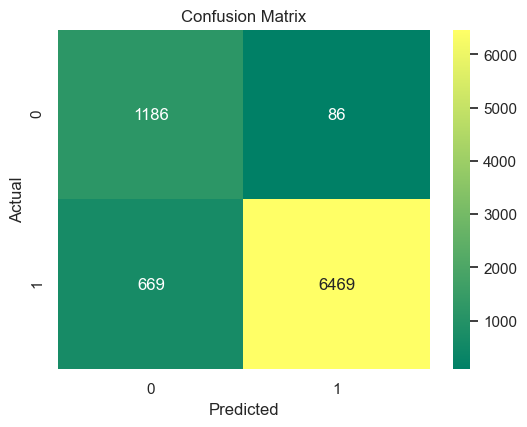

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(6,4.5)})
plt.rcParams["figure.dpi"] = 100


cm = confusion_matrix(y_test,giniPred)
sns.heatmap(cm, annot=True,cmap="summer", fmt="d"); #annot=True to annotate cells
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

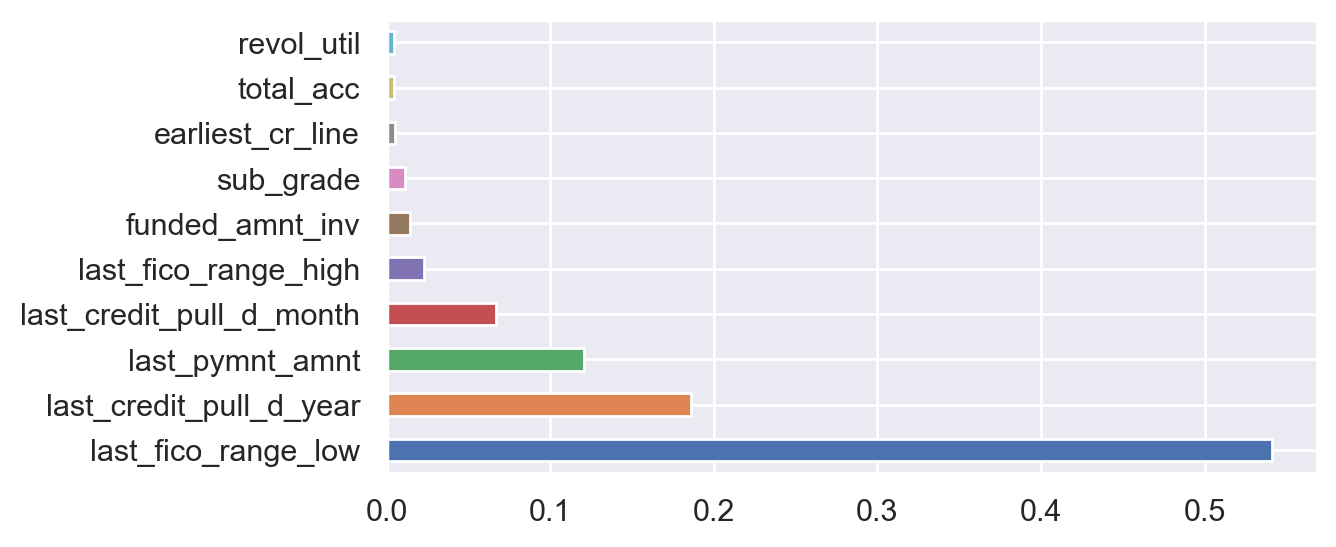

In [ ]:
import matplotlib
sns.set(rc={'figure.figsize':(6,3)})
#sns.set_style('whitegrid')

matplotlib.rcParams["figure.dpi"] = 200
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig('feature_imp.png', dpi=100)
plt.show()

In [ ]:
feat_importances.nlargest(10)

last_fico_range_low         0.541311
last_credit_pull_d_year     0.186010
last_pymnt_amnt             0.120904
last_credit_pull_d_month    0.066642
last_fico_range_high        0.022985
funded_amnt_inv             0.014077
sub_grade                   0.011402
earliest_cr_line            0.005051
total_acc                   0.004879
revol_util                  0.004754
dtype: float64